Imports & setup

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from scipy.stats import randint, loguniform

import joblib
from sklearn.metrics import precision_recall_curve
import json, pathlib

In [2]:
sns.set(style="whitegrid")

RESULTS_DIR = Path("../results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR  = Path("../models");  MODELS_DIR.mkdir(parents=True, exist_ok=True)


Load the feature-selected dataset (best from Notebook 04)

In [3]:
df = pd.read_csv("../data/heart_selected.csv")
target_col = "target"
X = df.drop(columns=[target_col])
y = df[target_col]

print("Selected dataset:", X.shape, "features,", y.shape[0], "rows")


Selected dataset: (303, 18) features, 303 rows


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (242, 18)  Test: (61, 18)


Common preprocessor (impute + scale all)

In [5]:
pre = ColumnTransformer(transformers=[("all", Pipeline([("imp", SimpleImputer(strategy="median")),("scaler", StandardScaler())]), list(X.columns))],remainder="drop")

In [6]:
def eval_on_test(pipe, X_test, y_test, name="model"):
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    out = {
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall":    recall_score(y_test, y_pred),
        "f1":        f1_score(y_test, y_pred),
        "auc":       roc_auc_score(y_test, y_proba),
        "name":      name
    }
    return out

Baseline models

In [7]:
baseline_models = {
    "logreg_base": Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=2000, random_state=42))]),
    "rf_base":     Pipeline([("pre", pre), ("clf", RandomForestClassifier(n_estimators=300, random_state=42))]),
    "svm_base":    Pipeline([("pre", pre), ("clf", SVC(kernel="rbf", probability=True, random_state=42))]),}

baseline_metrics = {}
for name, pipe in baseline_models.items():
    pipe.fit(X_train, y_train)
    baseline_metrics[name] = eval_on_test(pipe, X_test, y_test, name=name)

pd.DataFrame(baseline_metrics).T

,accuracy,precision,recall,f1,auc,name
logreg_base,0.885246,0.862069,0.892857,0.877193,0.962121,logreg_base
rf_base,0.885246,0.83871,0.928571,0.881356,0.945346,rf_base
svm_base,0.852459,0.851852,0.821429,0.836364,0.948052,svm_base


Tuning — GridSearchCV for Logistic Regression

In [8]:
logreg = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=5000, random_state=42))])

param_grid = [
    {"clf__solver": ["lbfgs", "newton-cg", "saga"],
     "clf__penalty": ["l2"],
     "clf__C": np.logspace(-3, 2, 12),
     "clf__class_weight": [None, "balanced"]},
    {"clf__solver": ["liblinear"],
     "clf__penalty": ["l1", "l2"],
     "clf__C": np.logspace(-3, 2, 12),
     "clf__class_weight": [None, "balanced"]},
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_logreg = GridSearchCV(logreg, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True, verbose=0)
gs_logreg.fit(X_train, y_train)

print("LogReg best params:", gs_logreg.best_params_)
print("LogReg best CV AUC:", gs_logreg.best_score_)


LogReg best params: {'clf__C': np.float64(0.0657933224657568), 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
LogReg best CV AUC: 0.9130637478463566


In [9]:
pd.DataFrame(gs_logreg.cv_results_).to_csv(RESULTS_DIR / "gridsearch_logreg_results.csv", index=False)


Tuning — RandomizedSearchCV for Random Forest

In [10]:
rf = Pipeline([("pre", pre), ("clf", RandomForestClassifier(random_state=42))])

rf_dist = {
    "clf__n_estimators": randint(200, 900),
    "clf__max_depth": randint(2, 30),
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 10),
    "clf__max_features": ["sqrt", "log2", None],
    "clf__bootstrap": [True, False],
}

rs_rf = RandomizedSearchCV(
    rf, rf_dist, n_iter=60, cv=cv, scoring="roc_auc",
    n_jobs=-1, refit=True, random_state=42, verbose=0
)
rs_rf.fit(X_train, y_train)

print("RF best params:", rs_rf.best_params_)
print("RF best CV AUC:", rs_rf.best_score_)

pd.DataFrame(rs_rf.cv_results_).to_csv(RESULTS_DIR / "randomsearch_rf_results.csv", index=False)


RF best params: {'clf__bootstrap': True, 'clf__max_depth': 4, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 455}
RF best CV AUC: 0.9001711653885568


Tuning — RandomizedSearchCV for SVM (RBF)

In [11]:
svm = Pipeline([("pre", pre), ("clf", SVC(kernel="rbf", probability=True, random_state=42))])

svm_dist = {
    "clf__C":     loguniform(1e-3, 1e3),
    "clf__gamma": loguniform(1e-4, 1e0),
    "clf__class_weight": [None, "balanced"]
}

rs_svm = RandomizedSearchCV(
    svm, svm_dist, n_iter=60, cv=cv, scoring="roc_auc",
    n_jobs=-1, refit=True, random_state=42, verbose=0
)
rs_svm.fit(X_train, y_train)

print("SVM best params:", rs_svm.best_params_)
print("SVM best CV AUC:", rs_svm.best_score_)

pd.DataFrame(rs_svm.cv_results_).to_csv(RESULTS_DIR / "randomsearch_svm_results.csv", index=False)


SVM best params: {'clf__C': np.float64(0.016533597028439553), 'clf__class_weight': None, 'clf__gamma': np.float64(0.0002031980983842498)}
SVM best CV AUC: 0.9098690359559924


Evaluate tuned models on the test set

In [12]:
tuned = {
    "logreg_tuned": gs_logreg.best_estimator_,
    "rf_tuned":     rs_rf.best_estimator_,
    "svm_tuned":    rs_svm.best_estimator_,
}

tuned_metrics = {name: eval_on_test(pipe, X_test, y_test, name=name) for name, pipe in tuned.items()}

# Combine baseline vs tuned
baseline_df = pd.DataFrame(baseline_metrics).T
tuned_df    = pd.DataFrame(tuned_metrics).T

comparison = (pd.concat([baseline_df, tuned_df])
              .reset_index(drop=False)
              .rename(columns={"index":"model"}))
comparison = comparison[["model","accuracy","precision","recall","f1","auc"]].sort_values("auc", ascending=False)
display(comparison)

comparison.to_csv(RESULTS_DIR / "tuning_comparison_baseline_vs_tuned.csv", index=False)


c:\Users\LaptopAcademy.pro\Desktop\ML Full Pipeline on Heart Disease UCI Dataset\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model,accuracy,precision,recall,f1,auc
3,logreg_tuned,0.868852,0.8125,0.928571,0.866667,0.967532
5,svm_tuned,0.540984,0.0,0.0,0.0,0.967532
0,logreg_base,0.885246,0.862069,0.892857,0.877193,0.962121
4,rf_tuned,0.885246,0.83871,0.928571,0.881356,0.950216
2,svm_base,0.852459,0.851852,0.821429,0.836364,0.948052
1,rf_base,0.885246,0.83871,0.928571,0.881356,0.945346


In [ ]:


def metrics_at_best_threshold(pipe, X_test, y_test, name):
    y_proba = pipe.predict_proba(X_test)[:, 1]
    prec, rec, thr = precision_recall_curve(y_test, y_proba)
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    i = int(np.nanargmax(f1s))
    best_thr = float(thr[i]) if i < len(thr) else 0.5
    y_pred = (y_proba >= best_thr).astype(int)
    return {
        "model": name,
        "best_thr": best_thr,
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall":    recall_score(y_test, y_pred),
        "f1":        f1_score(y_test, y_pred),
        "auc":       roc_auc_score(y_test, y_proba),
    }

thr_rows = []
best_thresholds = {}
for name, pipe in tuned.items():
    m = metrics_at_best_threshold(pipe, X_test, y_test, name)
    thr_rows.append(m)
    best_thresholds[name] = m["best_thr"]

thr_df = pd.DataFrame(thr_rows).sort_values("f1", ascending=False)
display(thr_df)

(pathlib.Path("../results")).mkdir(exist_ok=True, parents=True)
with open("../results/best_thresholds.json", "w") as f:
    json.dump(best_thresholds, f, indent=2)
print("Saved thresholds to ../results/best_thresholds.json")


,model,best_thr,accuracy,precision,recall,f1,auc
0,logreg_tuned,0.675092,0.934426,0.928571,0.928571,0.928571,0.967532
2,svm_tuned,0.744225,0.918033,0.870968,0.964286,0.915254,0.967532
1,rf_tuned,0.568968,0.901639,0.923077,0.857143,0.888889,0.950216


Saved thresholds to ../results/best_thresholds.json


ROC curves (tuned only) + Confusion matrices

<Figure size 600x500 with 0 Axes>

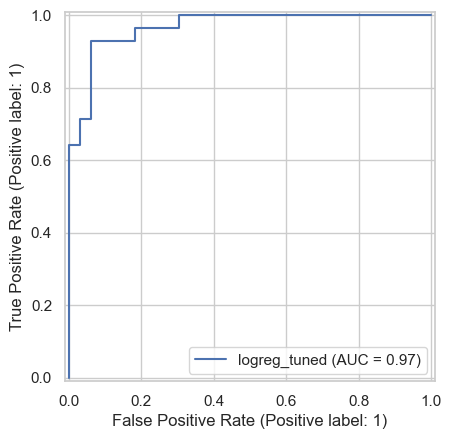

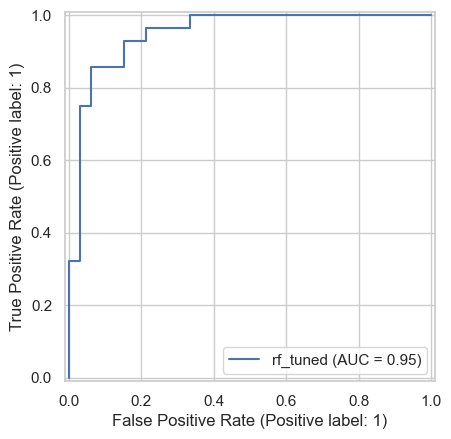

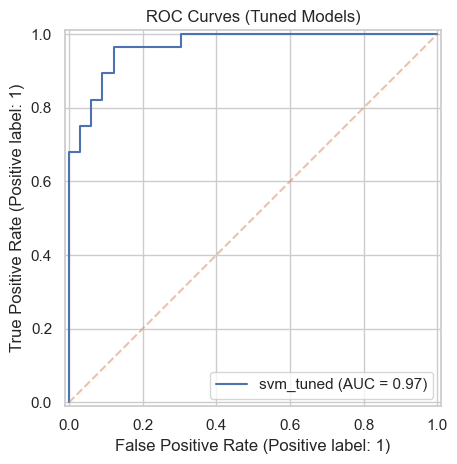

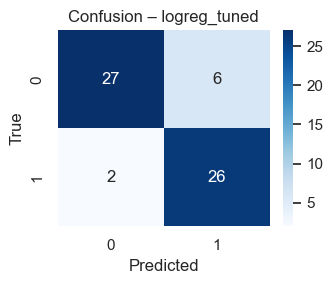

Classification Report – logreg_tuned
              precision    recall  f1-score   support

           0      0.931     0.818     0.871        33
           1      0.812     0.929     0.867        28

    accuracy                          0.869        61
   macro avg      0.872     0.873     0.869        61
weighted avg      0.877     0.869     0.869        61



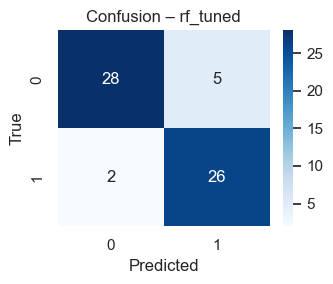

Classification Report – rf_tuned
              precision    recall  f1-score   support

           0      0.933     0.848     0.889        33
           1      0.839     0.929     0.881        28

    accuracy                          0.885        61
   macro avg      0.886     0.889     0.885        61
weighted avg      0.890     0.885     0.885        61



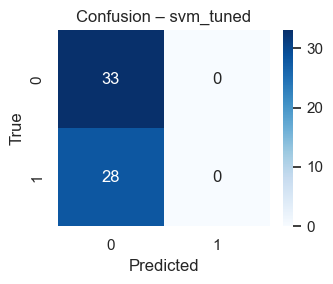

Classification Report – svm_tuned
              precision    recall  f1-score   support

           0      0.541     1.000     0.702        33
           1      0.000     0.000     0.000        28

    accuracy                          0.541        61
   macro avg      0.270     0.500     0.351        61
weighted avg      0.293     0.541     0.380        61



c:\Users\LaptopAcademy.pro\Desktop\ML Full Pipeline on Heart Disease UCI Dataset\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LaptopAcademy.pro\Desktop\ML Full Pipeline on Heart Disease UCI Dataset\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\LaptopAcademy.pro\Desktop\ML Full Pipeline on Heart Disease UCI Dataset\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

In [13]:
plt.figure(figsize=(6,5))
for name, pipe in tuned.items():
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)
plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.title("ROC Curves (Tuned Models)")
plt.tight_layout(); plt.show()

# Confusion matrices
for name, pipe in tuned.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3.5,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion – {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    print(f"Classification Report – {name}")
    print(classification_report(y_test, y_pred, digits=3))

Choose the best tuned model, save it as project default


In [14]:
best_row = comparison.iloc[0]
best_name = best_row["model"]
best_pipe = tuned.get(best_name, None)  

if best_pipe is None:
    best_name = "logreg_tuned"
    best_pipe = tuned["logreg_tuned"]

joblib.dump(best_pipe, MODELS_DIR / "final_model.pkl")
comparison.to_csv(RESULTS_DIR / "final_tuned_metrics.csv", index=False)

print(f"Best model: {best_name}  (AUC={best_row['auc']:.3f})")
print("Saved tuned model to ../models/final_model.pkl")
print("Saved comparison tables to ../results/")


Best model: logreg_tuned  (AUC=0.968)
Saved tuned model to ../models/final_model.pkl
Saved comparison tables to ../results/
